In [1]:
#This script uses primer3 to calculate free-energy of dimerization for all the primers generated in the previous script. 
#This script requires a local installation of primer3.

import os
import subprocess
from time import time

#Defining classes to help with storing primer information
class gene:
    def __init__(self, name, primers):
        self.name = name
        self.primers = primers
        return
    
class primer_pair:
    def __init__(self, A, B, name, count):
        self.id = f"{name}-{count}"
        self.gene = name
        self.fseq = A.split("+")[0]
        self.rseq = A.split("+")[3]
        self.fstart = A.split("+")[2]
        self.penalty = B.split("-")[0]
        self.ftm = B.split("-")[1]
        self.rtm = B.split("-")[2]
        self.ampliconlen = B.split("-")[3]
        self.path = []
        self.neighbours = []
        return
            

#specify the location of the output of the primer generator script
os.chdir("/home/flan3@ad.wisc.edu/MplexPrimerPicker/projects/mockcommunity/")

In [3]:
#load the primer lists generated by the last script
import pickle
with open("Primers.pickle", "rb") as infile:
    genelist = pickle.load(infile)

#format the list of genes and fix primer names
glist = []
count = 0
for g in genelist:
    plist = []
    for p in genelist[g]:
        plist.append(p)
        count+= 1
    glist.append(gene(p.gene.split("|")[-2:], plist))
    print(p.gene)
genelist = glist
print(count, "total primers")

#truncate primers from 3' end to 60bp because ntthal the thermodynamics calculator cannot take >60bp long oligos.
for g in genelist:
    for p in g.primers:
        if len(p.fseq) > 60: #ntthal can't take longer than 60bp long
            p.fseq = p.fseq[len(p.fseq)-60:] #so we truncate from 5'            
        if len(p.rseq) > 60: #ntthal can't take longer than 60bp long

            p.rseq = p.rseq[len(p.rseq)-60:] #so we truncate from 5'

Sepiderm-dnaG
Pputida-dnaG
Llactis-dnaG
Bfragilis-rpoB
Chiranonis-rpoB
Ecoli-rpoB
Bsubtilis-rpoB
RFP
P5/P7
16S
802 total primers


In [4]:
#define functions to run ntthal (the program that checks primer dimer deltaGs)

#command to run ntthal, the thermodynamic calculator of primer3
#ntthal is located in the primer3 installation directory as shown below
ntthal = "~/primer3/src/ntthal -mv 200 -dv 3 -n 0.2 -t 25 -d 50"  #calculate at 25C, 200mM Naccl, 3mM Mgcl, 0.2mM dNTP, 60oC temp, 50nM primers

#This function runs ntthal for 2 input sequences, comparing the deltaG of hybridization of end-hybridization of both primers to another
#This function returns the lowest deltaG from the two comparisons
def run_ntthal(s1, s2):
    try:
        stream = os.popen(f"{ntthal} -s1 {s1} -s2 {s2} -a END1")
        l = stream.readlines()[0].split()
        score1 = float(l[13])
    except:
        print(stream.readlines())
        score1 = 999
     
    try:
        stream = os.popen(f"{ntthal} -s1 {s1} -s2 {s2} -a END2")
        l = stream.readlines()[0].split()
        score2 = float(l[13])
    except:
        print(stream.readlines())
        score2 = 999    
        
    return min(score1, score2)

#function to check the dimer deltaGs between ith gene in the list against other genes in the list (that's 4 primers cross checked)
#stores the results in an adjacency dictionary of (primerset1,primerset2):mindeltaG
def check_genes(gene, i):
    adjdict = {} #create a local dict to store these things
    for p in gene.primers: #loop through each primer under gene i
        seqs = [0,0,0,0]
        ID = p.id
        seqs[0] = p.fseq
        seqs[1] = p.rseq
        homoGs = []

        #first check self-dimerization once so we don't keep repeating it
        for s in seqs[0:2]:
            homoGs.append(run_ntthal(s, s))
            
        for j in range(i+1, len(genelist)): #for each other gene
            for q in genelist[j].primers: #loop through primers under other genes
                #ts = process_time()
                ID2 = q.id
                seqs[2] = q.fseq
                seqs[3] = q.rseq          
                deltaGs = list(homoGs)

                #do all-way comparisons (completely check for dimers self and hetero)
                #check homodimerization for the other 2 sequences
                for s in seqs[2:4]:
                    deltaGs.append(run_ntthal(s, s))
                #now check for cross-dimerization
                for z in range(4):
                    for y in range(4):
                        if z != y: #skip the homo check steps
                            deltaGs.append(run_ntthal(seqs[y], seqs[z])) #check all heterocombinations, AB != BA when doing End comparisons
                
                #add to the adjacency dictionary
                adjdict[frozenset((ID,ID2))] = min(deltaGs) #add the worst deltaGs
                #print(process_time()-ts) - timing one primer-v-primer comparison - takes 0.015s
    return adjdict



In [5]:
#parallelized calculation of thermodynamic binding energies for primer pairs using the above functions
import multiprocessing
from joblib import Parallel, delayed

num_cores = multiprocessing.cpu_count() #number of cores to use, defaults to all cores

t1 = time()  #to keep track of how long the job took
adjdictlist = Parallel(n_jobs=num_cores)(delayed(check_genes)(genelist[i], i) for i in range(len(genelist))) #do the parallelized adjmatrix calculations

#merge all outputs of different jobs into a single datastructure
adjdict = {}
for d in adjdictlist:
    adjdict.update(d)

#store results on harddrive as a pickle, this file will be used by the third script to pick primer pools
import pickle
with open("dimerization-deltaGs.pickle", "wb") as outfile:
    pickle.dump(adjdict, outfile)

t2 = time() #keep track of how long the job took
    
print(f"running on {num_cores} took {t2 - t1} seconds")


running on 32 took 12652.21362566948 seconds


(array([5.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.0000e+00, 6.7000e+01, 0.0000e+00, 3.1000e+01, 1.9000e+01,
        1.2300e+02, 1.4910e+03, 3.7000e+01, 4.9930e+03, 4.3970e+03,
        6.2190e+03, 2.3000e+03, 3.0800e+02, 1.1530e+03, 2.3300e+03,
        2.3630e+03, 7.2130e+03, 3.5620e+03, 2.2500e+03, 2.2810e+03,
        7.7250e+03, 5.2360e+03, 3.0510e+03, 5.5640e+03, 1.1707e+04,
        1.1780e+04, 1.3673e+04, 1.7320e+04, 1.3323e+04, 1.7397e+04,
        2.4379e+04, 2.2284e+04, 2.1028e+04, 2.2201e+04, 1.6986e+04,
        8.0220e+03, 7.9000e+03, 4.6570e+03, 3.7200e+03, 1.4280e+03,
        7.3300e+02, 2.9700e+02, 2.4000e+01, 1.3000e+01, 7.0000e+00]),
 array([-17681.4   , -17348.8616, -17016.3232, -16683.7848, -16351.2464,
        -16018.708 , -15686.1696, -15353.6312, -15021.0928, -14688.5544,
        -14356.016 , -14023.4776, -13690.9392, -13358.4008, -13025.8624,
        -12693.324 , -12360.7856, -12028.2472, -11695.7088, -11363.1704,
        -11030.632 , -1069

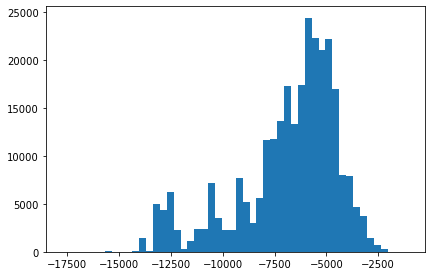

In [6]:
#visualize the distribution of deltaGs 
import matplotlib.pyplot as plot

#check the distributions of deltaGs and Tms
dGs =[]

for v in adjdict.values():
    dGs.append(v)

fig, axs = plot.subplots()
fig.tight_layout()

axs.hist(dGs, bins = 50)
